In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from data import *
from window import *
import matplotlib.pyplot as plt
import numpy as np

ticker = 'IESC'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [2]:
def backtest_strategy_long_short(data):
    """ Simulate trading based on provided buy and sell signals, including tracking entry and exit prices. """
    capital = 10000
    shares = 0
    short_shares = 0  # Track short positions separately
    portfolio = pd.DataFrame(index=data.index, columns=['Portfolio Value', 'Entry Price', 'Exit Price', 'Position Type'])
    entry_price = None
    exit_price = None
    prev_signal = None 
    in_position = False
    short_position = False

    for row_index in range(0, len(data)): 
        signal = generate_signals(data, row_index)
        current_price = data.iloc[row_index]['Close']
    
        if (signal == 'Buy' and not in_position) and (prev_signal != 'Buy' and capital > 0):
            shares_to_buy = capital / current_price
            shares += shares_to_buy
            capital -= shares_to_buy * current_price
            entry_price = current_price

            exit_price = None
            in_position = True 
            portfolio.loc[data.index[row_index], 'Position Type'] = 'Long'

        if (prev_signal == 'Buy' and entry_price is not None and current_price <= entry_price * 0.9) or (signal == 'Sell' and prev_signal != 'Sell' and shares > 0):
            capital += shares * current_price
            shares = 0
            exit_price = current_price
            entry_price = None
            in_position = False
            portfolio.loc[data.index[row_index], 'Position Type'] = 'None'

        if (signal == 'Sell' and not short_position) and (prev_signal != 'Sell' and not in_position):
            shares_to_short = capital / current_price
            short_shares += shares_to_short
            capital += short_shares * current_price
            entry_price = current_price

            exit_price = None
            short_position = True 
            portfolio.loc[data.index[row_index], 'Position Type'] = 'Short'

        if (prev_signal == 'Sell' and entry_price is not None and current_price >= entry_price * 1.1) or (signal == 'Buy' and prev_signal != 'Buy' and short_shares > 0):
            capital -= short_shares * current_price
            short_shares = 0
            exit_price = current_price
            entry_price = None
            short_position = False
            portfolio.loc[data.index[row_index], 'Position Type'] = 'None'

        portfolio_value = capital + (shares * current_price) - (short_shares * current_price)
        portfolio.loc[data.index[row_index], 'Entry Price'] = entry_price
        portfolio.loc[data.index[row_index], 'Portfolio Value'] = portfolio_value
        portfolio.loc[data.index[row_index], 'Exit Price'] = exit_price
        
        prev_signal = signal

    return portfolio.fillna(0)


def calculate_performance(portfolio):
    """ Calculate the percent change in portfolio value from the first day to the last. """
    first_day_value = portfolio.iloc[0]['Portfolio Value']
    last_day_value = portfolio.iloc[-1]['Portfolio Value']
    percent_change = ((last_day_value - first_day_value) / first_day_value) * 100
    return percent_change

# Set start date as 60 days before today and end date as today
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

# # Running the backtest
# tickers = ['SPY', 'NDAQ','JPM', 'C', 'BAC', 'PANW', 'SHOP', 'NET', 'TSM', 'CRM', 'ON', 'SONY', 'CRWD', 'AMAT', 'AMZN', 'AAPL']

# for ticker in tickers: 
#     data = fetch_data(ticker, start_date, end_date)
#     portfolio = backtest_strategy_long_short(data)
#     performance = calculate_performance(portfolio)
#     print(f"Performance of {ticker} is {performance:.2f}%")

# # Display results
# print(portfolio)

[*********************100%%**********************]  1 of 1 completed


Performance of NVDA is 3.33%


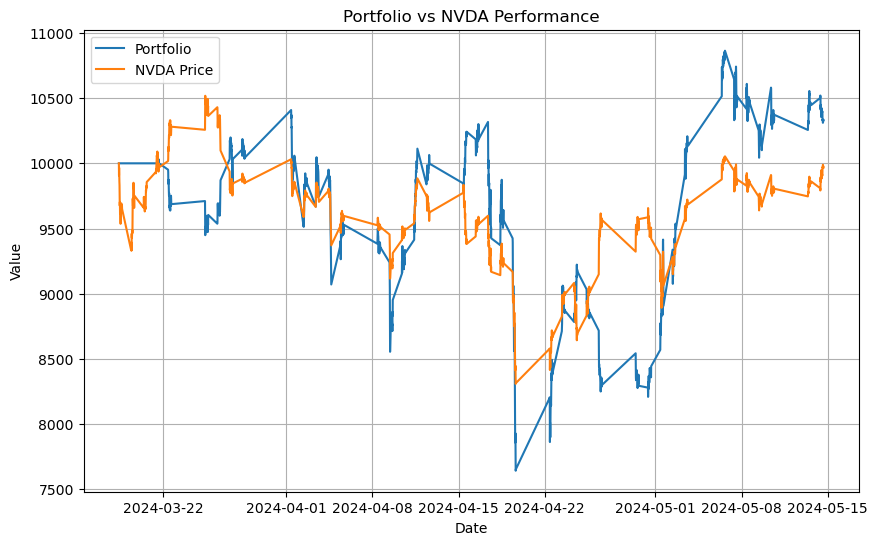

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


ticker = 'NVDA'
start_date = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

data = fetch_data(ticker, start_date, end_date)

# Normalizing the stock data
stock_data = data['Close'] * 20
initial_stock_value = stock_data.iloc[0]
normalized_stock_data = (stock_data / initial_stock_value) * 10000

# Backtest the strategy
portfolio = backtest_strategy_long_short(data)

# Normalizing the portfolio data
initial_portfolio_value = portfolio['Portfolio Value'].iloc[0]
normalized_portfolio = (portfolio['Portfolio Value'] / initial_portfolio_value) * 10000

performance = calculate_performance(portfolio)
print(f"Performance of {ticker} is {performance:.2f}%")

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(portfolio.index, normalized_portfolio, label='Portfolio')
plt.plot(stock_data.index, normalized_stock_data, label=f'{ticker} Price')
plt.title(f'Portfolio vs {ticker} Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()